Code adapted from [https://github.com/thibautissenhuth/consistency_GC](https://github.com/thibautissenhuth/consistency_GC)

In [2]:
import torch
import matplotlib.pyplot as plt

import numpy as np
from matplotlib.ticker import ScalarFormatter

In [3]:
def return_gaussians(size):
    means = [(0,-0.5),(0,0.5)]
    var = 0.05
    x = torch.FloatTensor([])
    for mean_tuple in means:
        gauss = torch.randn((size//len(means),2)) * var
        gauss[:,0] += mean_tuple[0]
        gauss[:,1] += mean_tuple[1]
        x = torch.cat((x, gauss),dim=0)
    return x

def return_input_distrib(size):
    means = [(0,0)]
    var = (1., 1.)
    x = torch.FloatTensor([])
    for mean_tuple in means:
        gauss = torch.randn((size//len(means),2))
        gauss[:,0] = mean_tuple[0] + gauss[:,0] * var[0]
        gauss[:,1] = mean_tuple[1] + gauss[:,1] * var[1]
        x = torch.cat((x, gauss),dim=0)
    return x

def construct_test_batch(sigmas, device):
    x_A = torch.FloatTensor([1.,.5]).to(device)
    x_B = torch.FloatTensor([1.,-0.5]).to(device)

    z_A = torch.FloatTensor([-1.,1.]).to(device)
    z_B = torch.FloatTensor([-1.,-1.]).to(device)

    n_sigmas = len(sigmas)
    n_points = n_sigmas * 6
    x_test = torch.zeros((n_points, 2)).to(device)
    z_test = torch.zeros((n_points, 2)).to(device)
    x_i_test = torch.zeros((n_points, 2)).to(device)
    sigmas_test = torch.zeros((n_points)).to(device)

    for i in range(n_sigmas):
        sigma_i = sigmas[i].to(device)
        x_i_test[4*i,:] = (1 - sigma_i) * x_A + sigma_i * z_A
        x_i_test[4*i + 1,:] = (1 - sigma_i) * x_A + sigma_i * z_B
        x_i_test[4*i + 2,:] = (1 - sigma_i) * x_B + sigma_i * z_A
        x_i_test[4*i + 3,:] = (1 - sigma_i) * x_B + sigma_i * z_B

        x_test[4*i,:] = x_A
        x_test[4*i+1,:] = x_A
        x_test[4*i+2,:] = x_B
        x_test[4*i+3,:] = x_B

        z_test[4*i,:] = z_A
        z_test[4*i+1,:] = z_B
        z_test[4*i+2,:] = z_A
        z_test[4*i+3,:] = z_B
        sigmas_test[4*i:5*i] = sigma_i
    return x_test, x_i_test, z_test, sigmas_test


In [4]:
class PositionalEmbedding(torch.nn.Module):
    def __init__(self, num_channels, max_positions=10000, endpoint=False):
        super().__init__()
        self.num_channels = num_channels
        self.max_positions = max_positions
        self.endpoint = endpoint

    def forward(self, x):
        freqs = torch.arange(start=0, end=self.num_channels//2, dtype=torch.float32, device=x.device)
        freqs = freqs / (self.num_channels // 2 - (1 if self.endpoint else 0))
        freqs = (1 / self.max_positions) ** freqs
        x = x.ger(freqs.to(x.dtype))
        x = torch.cat([x.cos(), x.sin()], dim=1)
        return x

class MLP(torch.nn.Module):
    def __init__(self, input_dim=2, output_dim=2, hidden_dim=256):
        super().__init__()
        self.map_noise = PositionalEmbedding(hidden_dim)
        self.net_0 = torch.nn.Sequential(torch.nn.Linear(input_dim, hidden_dim), torch.nn.GELU())
        self.net_1 = torch.nn.Sequential(torch.nn.Linear(2 * hidden_dim, hidden_dim), torch.nn.GELU(),
                                    torch.nn.Linear(hidden_dim, hidden_dim), torch.nn.GELU(),
                                    torch.nn.Linear(hidden_dim, output_dim))
    def forward(self, x, t, class_labels=None):
        t = self.map_noise(t)
        x = self.net_0(x)
        x = torch.cat((x,t),dim=1)
        x = self.net_1(x)
        return x

class ConsistencyModel(torch.nn.Module):
    def __init__(self, sigma_min, sigma_max, sigma_data=0.5, hidden_dim=256):
        super().__init__()
        self.sigma_min = sigma_min
        self.sigma_max = sigma_max
        self.sigma_data = sigma_data
        self.model = MLP(hidden_dim=hidden_dim)

    def forward(self, x, sigma):
        sigma = sigma.unsqueeze(1)
        c_skip = self.sigma_data**2 / ((sigma - self.sigma_min) ** 2 + self.sigma_data**2)
        c_out = (self.sigma_data * (sigma - self.sigma_min)) / (self.sigma_data**2 + sigma**2) ** 0.5
        c_in = 1  / (self.sigma_data ** 2 + sigma ** 2).sqrt()

        c_noise = sigma.log() / 4

        F_x = self.model((c_in * x), c_noise.flatten())
        D_x = c_skip * x + c_out * F_x.to(torch.float32)
        return D_x


In [6]:
from models.ict import ImprovedConsistencyTraining
import copy
from kernels.conditional_ot import ConditionalOTKernel

len_data = 10000
batch_size = 256
training_steps = 40000
lr = 0.0001
s0 = 10
s1 = 80
rho = 7
ema_rate=0.999
sigma_min = 0.002
sigma_max = 0.1
hidden_dim = 256
kl_loss_scale=0.001
kernel= ConditionalOTKernel(sigma_min, sigma_max, sigma_data=0.05)
generator_induced_trajectory = False
device = 'cpu'
coupling = 'vae' # choose vae or independent
print_freq = 1000
datapoints = return_gaussians(len_data)
dataset = torch.utils.data.TensorDataset(datapoints)
loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
###### Training Loop #########
current_training_step = 0
model = ImprovedConsistencyTraining(net=MLP(hidden_dim=hidden_dim),
                                    coupling=coupling,
                                    total_training_steps=training_steps,
                                    kernel=kernel,
                                    sigma_min=sigma_min,
                                    sigma_max=sigma_max,
                                    noise_schedule='uniform_time',
                                    sigma_data=0.05,
                                    start_scales=s0,
                                    end_scales=s1,
                                    loss_mode='l2',
                                    scale_mode='exp',
                                    encoder=MLP(hidden_dim=hidden_dim, output_dim=4),
                                    kl_loss_scale=kl_loss_scale,
                                    )
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
model_ema = copy.deepcopy(model).eval().requires_grad_(False)

@torch.no_grad()
def ema_update(model, ema_model, ema_rate):
    for p_ema, p_net in zip(ema_model.parameters(), model.parameters()):
        p_ema.copy_(p_net.detach().lerp(p_ema, ema_rate))
    return ema_model


step :  0
loss :  tensor(0.3251, grad_fn=<MeanBackward0>)


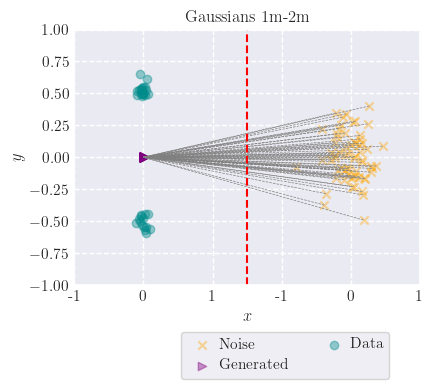

step :  1000
loss :  tensor(0.0435, grad_fn=<MeanBackward0>)


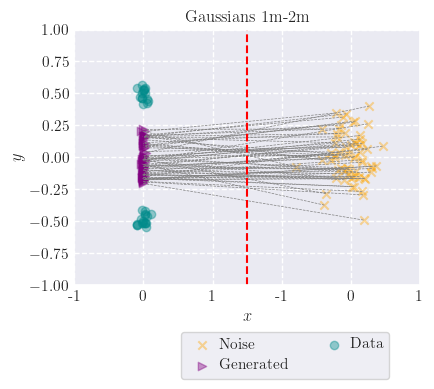

step :  2000
loss :  tensor(0.0398, grad_fn=<MeanBackward0>)


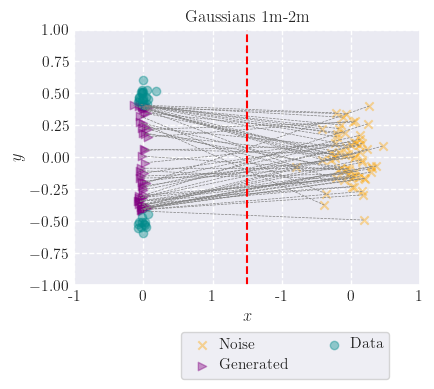

step :  3000
loss :  tensor(0.0356, grad_fn=<MeanBackward0>)


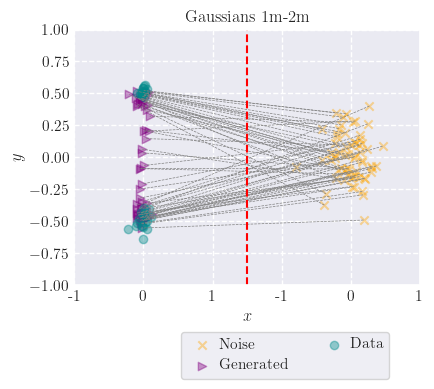

step :  4000
loss :  tensor(0.0347, grad_fn=<MeanBackward0>)


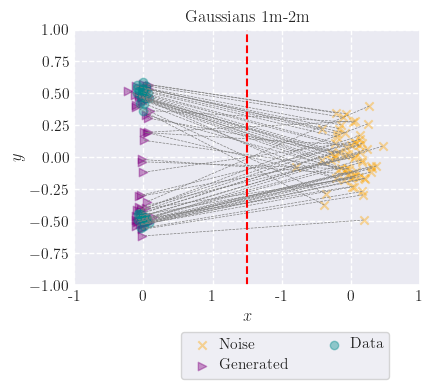

step :  5000
loss :  tensor(0.0328, grad_fn=<MeanBackward0>)


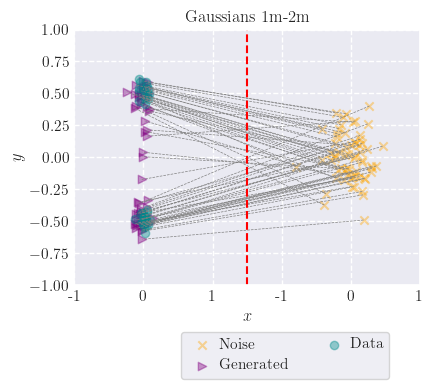

step :  6000
loss :  tensor(0.0319, grad_fn=<MeanBackward0>)


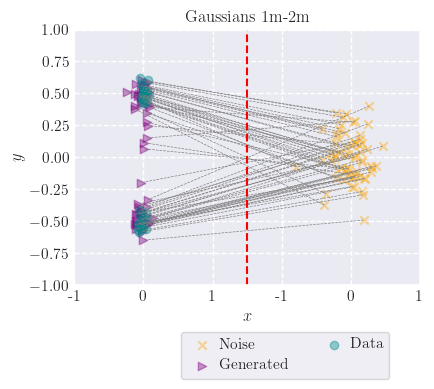

step :  7000
loss :  tensor(0.0343, grad_fn=<MeanBackward0>)


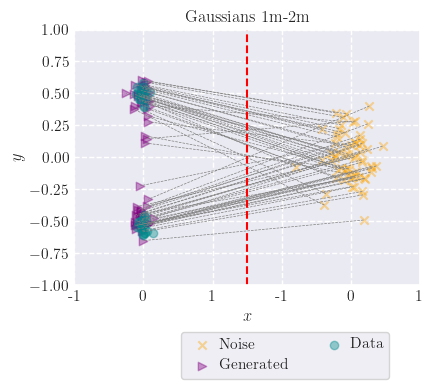

step :  8000
loss :  tensor(0.0317, grad_fn=<MeanBackward0>)


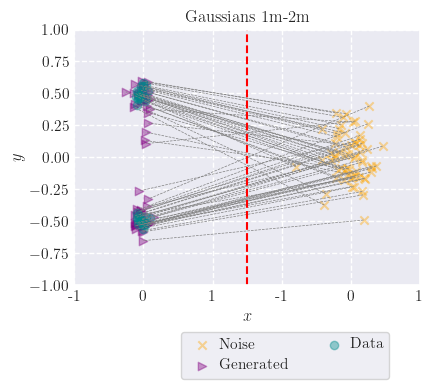

step :  9000
loss :  tensor(0.0331, grad_fn=<MeanBackward0>)


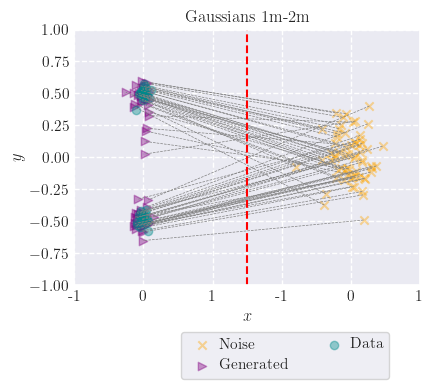

step :  10000
loss :  tensor(0.0547, grad_fn=<MeanBackward0>)


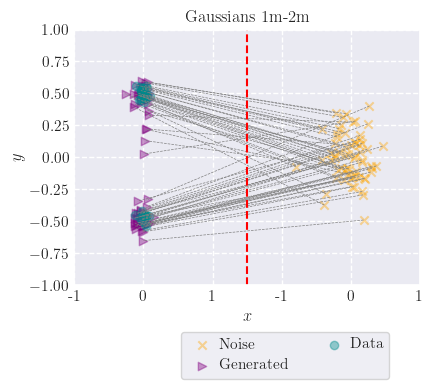

step :  11000
loss :  tensor(0.0469, grad_fn=<MeanBackward0>)


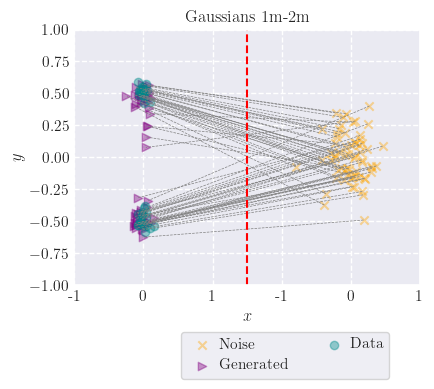

step :  12000
loss :  tensor(0.0528, grad_fn=<MeanBackward0>)


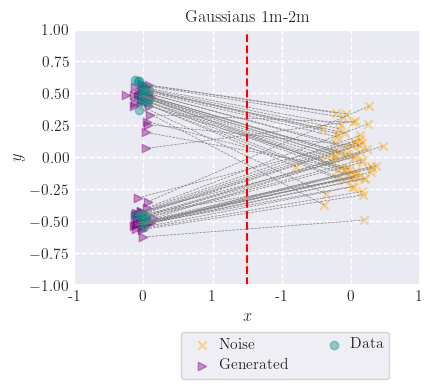

step :  13000
loss :  tensor(0.0470, grad_fn=<MeanBackward0>)


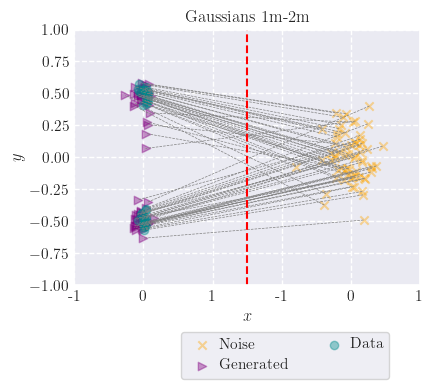

step :  14000
loss :  tensor(0.0529, grad_fn=<MeanBackward0>)


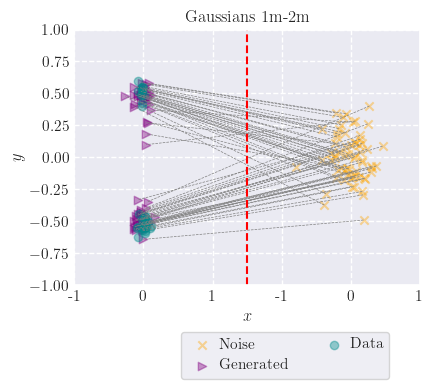

step :  15000
loss :  tensor(0.0492, grad_fn=<MeanBackward0>)


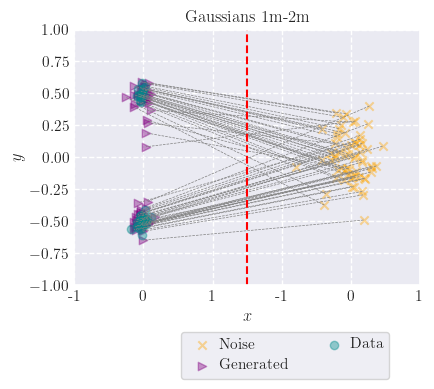

step :  16000
loss :  tensor(0.0833, grad_fn=<MeanBackward0>)


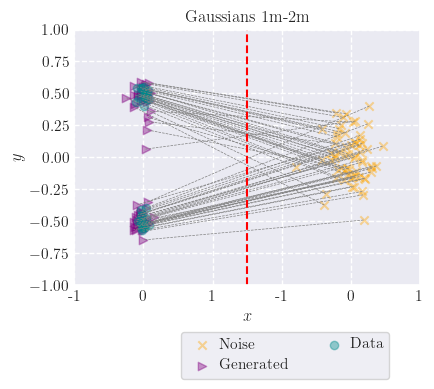

step :  17000
loss :  tensor(0.0425, grad_fn=<MeanBackward0>)


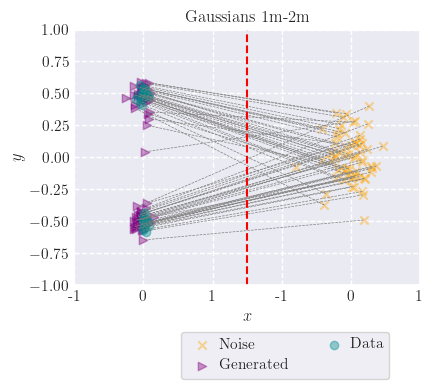

step :  18000
loss :  tensor(0.0478, grad_fn=<MeanBackward0>)


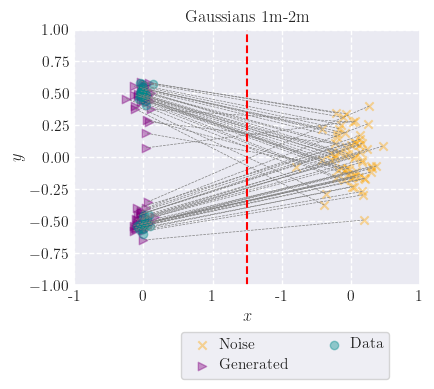

step :  19000
loss :  tensor(0.0441, grad_fn=<MeanBackward0>)


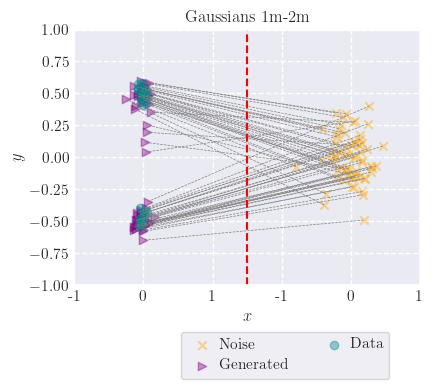

step :  20000
loss :  tensor(0.0890, grad_fn=<MeanBackward0>)


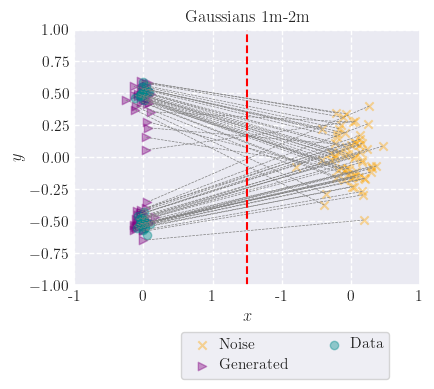

step :  21000
loss :  tensor(0.0781, grad_fn=<MeanBackward0>)


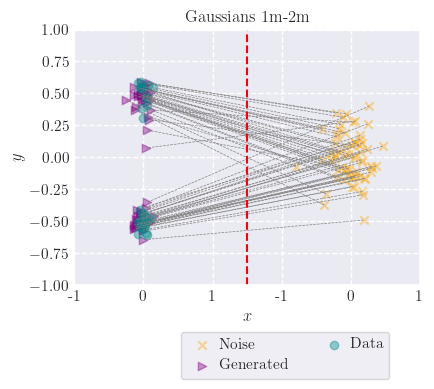

step :  22000
loss :  tensor(0.0783, grad_fn=<MeanBackward0>)


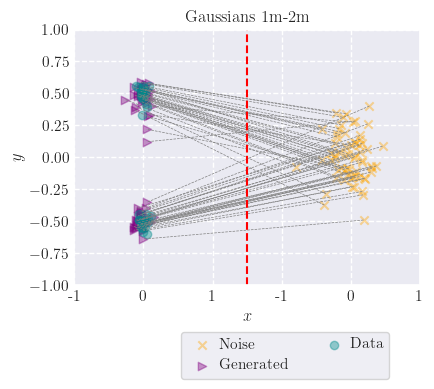

step :  23000
loss :  tensor(0.0774, grad_fn=<MeanBackward0>)


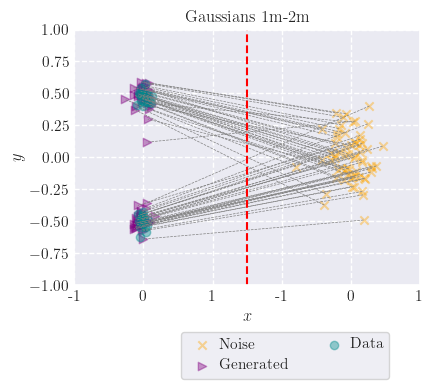

step :  24000
loss :  tensor(0.0720, grad_fn=<MeanBackward0>)


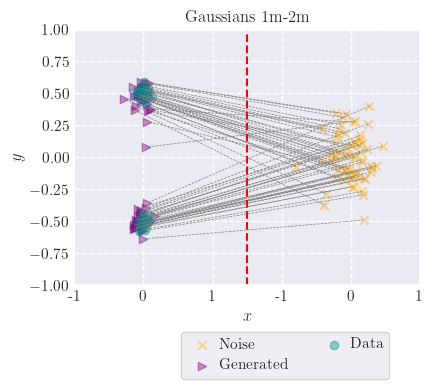

step :  25000
loss :  tensor(0.0745, grad_fn=<MeanBackward0>)


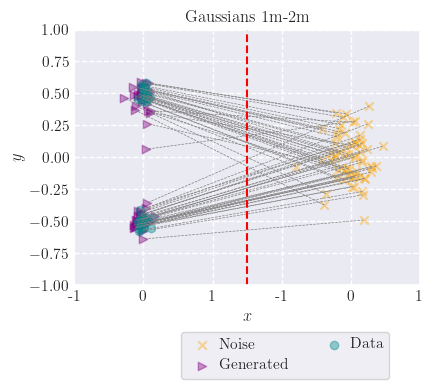

step :  26000
loss :  tensor(0.0766, grad_fn=<MeanBackward0>)


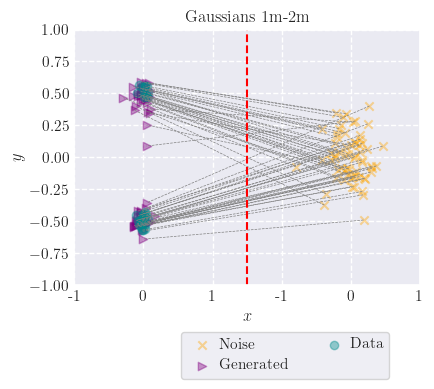

step :  27000
loss :  tensor(0.0756, grad_fn=<MeanBackward0>)


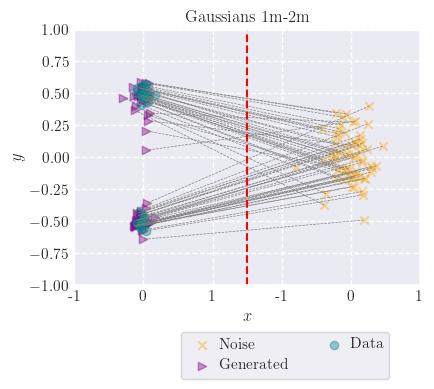

step :  28000
loss :  tensor(0.0778, grad_fn=<MeanBackward0>)


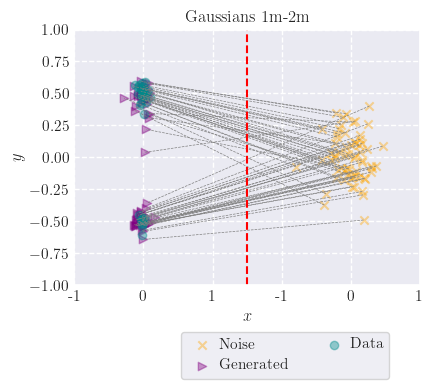

step :  29000
loss :  tensor(0.0768, grad_fn=<MeanBackward0>)


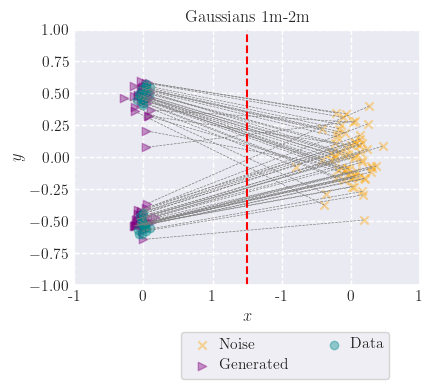

step :  30000
loss :  tensor(0.1462, grad_fn=<MeanBackward0>)


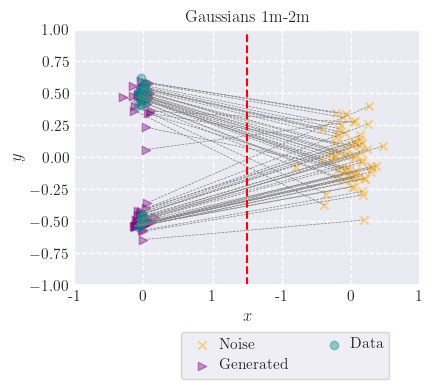

step :  31000
loss :  tensor(0.1560, grad_fn=<MeanBackward0>)


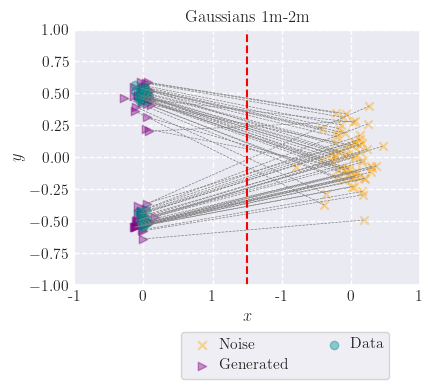

step :  32000
loss :  tensor(0.1268, grad_fn=<MeanBackward0>)


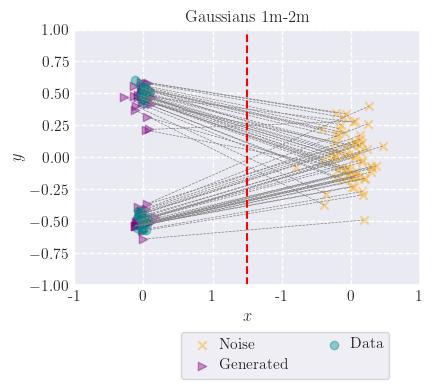

step :  33000
loss :  tensor(0.1396, grad_fn=<MeanBackward0>)


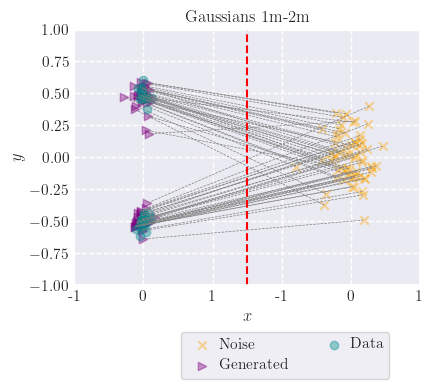

step :  34000
loss :  tensor(0.1357, grad_fn=<MeanBackward0>)


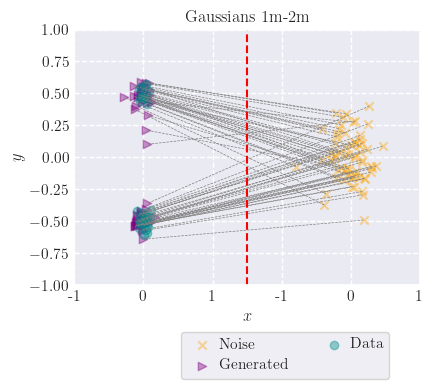

step :  35000
loss :  tensor(0.1330, grad_fn=<MeanBackward0>)


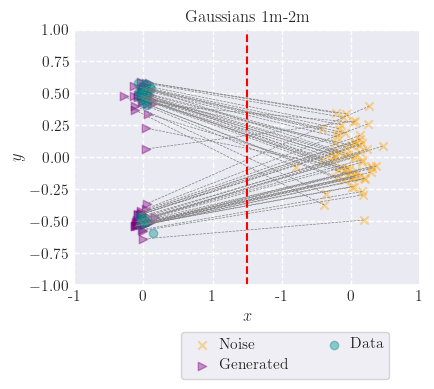

step :  36000
loss :  tensor(0.1377, grad_fn=<MeanBackward0>)


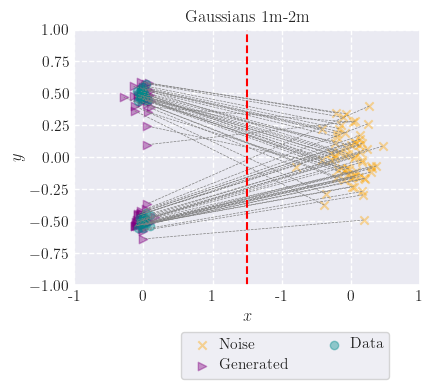

step :  37000
loss :  tensor(0.1414, grad_fn=<MeanBackward0>)


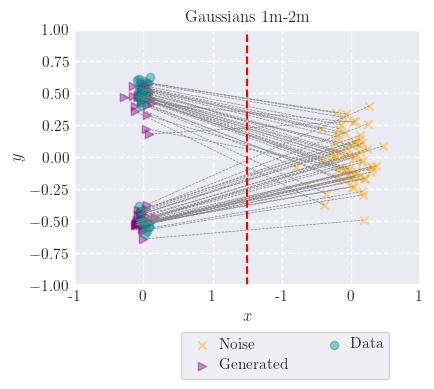

step :  38000
loss :  tensor(0.1450, grad_fn=<MeanBackward0>)


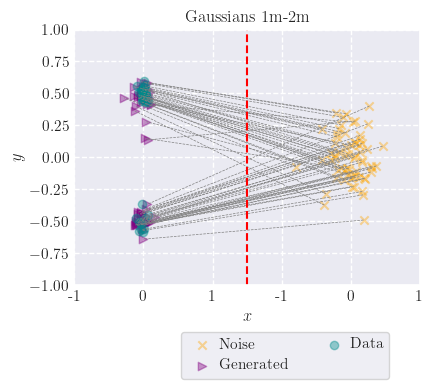

step :  39000
loss :  tensor(0.1306, grad_fn=<MeanBackward0>)


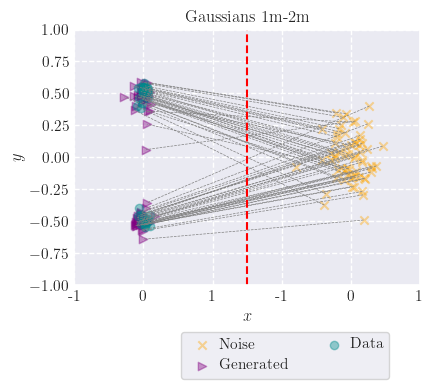

step :  40000
loss :  tensor(0.1349, grad_fn=<MeanBackward0>)


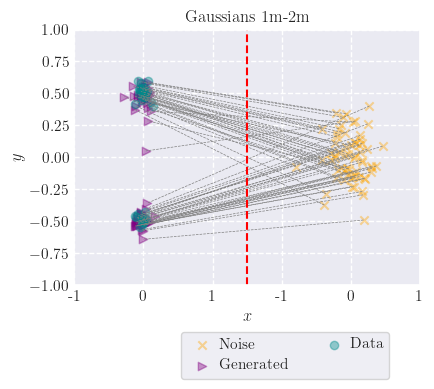

In [242]:
sample_noise = torch.randn_like(next(iter(loader))[0][:64]).to(device)
while True:
    for (idx, batch) in enumerate(loader):
        data = batch[0].to(device)
        optimizer.zero_grad()
        loss = model.loss(data, current_training_step)[0]
        loss.backward()
        optimizer.step()
        model_ema = ema_update(model, model_ema, ema_rate=ema_rate)
        if (current_training_step % print_freq) == 0:
            print('step : ', current_training_step)
            print('loss : ', loss)
            with torch.no_grad():
                dims = data.ndim
                noise = torch.randn_like(data)
                if model.coupling == 'vae':
                    data, noise, _, posterior = model.coupling_fn(data, noise, None)
                num_timesteps = model._step_schedule(current_training_step)

                sigmas = model._get_sigmas(num_timesteps, device=device)

                indices = model._get_indices(num_timesteps, sigmas, device=device, batch_size=batch_size)

        # sigma i + 1
                t = model._append_dims(sigmas[indices + 1], dims)
                r = model._append_dims(sigmas[indices], dims)
                batch_z_i = model.kernel.forward(data, r, noise)
                x_test, x_i_test, z_test, sigmas_test = data, batch_z_i, noise, r
                sigmas_max = r[:64] * 0 + sigma_max
                
                generated = model_ema.precond(sample_noise * sigmas_max, sigmas_max, None)
                fig, ax = plt.subplots( nrows=1, ncols=1, figsize=(4.5,3.5))
                data_pred_test = model_ema.precond(x_i_test, sigmas_test, None)
                ax.scatter(generated[:,0].cpu().numpy(), generated[:,1].cpu().numpy(), marker='>', alpha=0.4, label='Generated',color='purple')
                ax.scatter(data[:32,0].cpu().numpy(), data[:32,1].cpu().numpy(), marker='o', alpha=0.4, label='Data', color='darkcyan')
                ax.scatter(sample_noise[:,0].cpu().numpy()*sigma_max + 3, sample_noise[:,1].cpu().numpy()*sigma_max, marker='x', alpha=0.4, label='Noise',color='orange')
                # Adding lines connecting noise to generated points
                for i in range(len(sample_noise)):
                    ax.plot([sample_noise[i,0].cpu().numpy()*sigma_max + 3, generated[i,0].cpu().numpy()],
                            [sample_noise[i,1].cpu().numpy()*sigma_max, generated[i,1].cpu().numpy()],
                            color='gray', linestyle='--', linewidth=0.5)
                    
                ax.axvline(1.5, linestyle='--', color='red')

                ax.grid(linestyle='--')
                ax.set_axisbelow(True)
                ax.tick_params(axis="x", direction="in")
                ax.tick_params(axis="y", direction="in")
                ax.set_ylim([-1, 1])
                ax.set_xlim([-1, 4])
                ax.set_xticks([-1, 0, 1, 2, 3, 4], labels=[-1, 0, 1, -1, 0, 1])
                plt.xlabel(r'$x$')
                plt.ylabel(r'$y$')

                handles, legend_labels = ax.get_legend_handles_labels()
                handles =[handles[-1]] +  handles[:-1]
                legend_labels =[legend_labels[-1]] + legend_labels[:-1]
                fig.legend(handles, legend_labels, ncol=2, bbox_to_anchor=(0.9,0.05), handletextpad=0.1)
                ax.set_title(r'Gaussians 1m-2m')
                fig.tight_layout()
                fig.savefig(f'viz/generations_{current_training_step}_{coupling}.png', bbox_inches='tight')
                plt.show()

        current_training_step += 1
        if current_training_step == training_steps + 1:
            break
    if current_training_step == training_steps + 1:
        break
        
torch.save(model_ema.state_dict(), f'model_{coupling}_{kl_loss_scale}.pth')

In [7]:
import seaborn as sns
from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': 'Computer Modern Roman', 'size'   : 12})
rc('text', usetex=True)
ind_model = ImprovedConsistencyTraining(net=MLP(hidden_dim=hidden_dim),
                                    coupling='independent',
                                    total_training_steps=training_steps,
                                    kernel=kernel,
                                    sigma_min=sigma_min,
                                    sigma_max=sigma_max,
                                    noise_schedule='uniform_time',
                                    sigma_data=0.05,
                                    start_scales=s0,
                                    end_scales=s1,
                                    loss_mode='l2',
                                    scale_mode='exp',
                                    encoder=MLP(hidden_dim=hidden_dim, output_dim=4),
                                    kl_loss_scale=kl_loss_scale,
                                    )
ind_model.load_state_dict(torch.load(f'model_independent.pth', weights_only=True))
ind_model.eval()

ImprovedConsistencyTraining(
  (net): MLP(
    (map_noise): PositionalEmbedding()
    (net_0): Sequential(
      (0): Linear(in_features=2, out_features=256, bias=True)
      (1): GELU(approximate='none')
    )
    (net_1): Sequential(
      (0): Linear(in_features=512, out_features=256, bias=True)
      (1): GELU(approximate='none')
      (2): Linear(in_features=256, out_features=256, bias=True)
      (3): GELU(approximate='none')
      (4): Linear(in_features=256, out_features=2, bias=True)
    )
  )
  (kernel): ConditionalOTKernel()
  (encoder): MLP(
    (map_noise): PositionalEmbedding()
    (net_0): Sequential(
      (0): Linear(in_features=2, out_features=256, bias=True)
      (1): GELU(approximate='none')
    )
    (net_1): Sequential(
      (0): Linear(in_features=512, out_features=256, bias=True)
      (1): GELU(approximate='none')
      (2): Linear(in_features=256, out_features=256, bias=True)
      (3): GELU(approximate='none')
      (4): Linear(in_features=256, out_features

In [8]:
vae_model = ImprovedConsistencyTraining(net=MLP(hidden_dim=hidden_dim),
                                    coupling='vae',
                                    total_training_steps=training_steps,
                                    kernel=kernel,
                                    sigma_min=sigma_min,
                                    sigma_max=sigma_max,
                                    noise_schedule='uniform_time',
                                    sigma_data=0.05,
                                    start_scales=s0,
                                    end_scales=s1,
                                    loss_mode='l2',
                                    scale_mode='exp',
                                    encoder=MLP(hidden_dim=hidden_dim, output_dim=4),
                                    kl_loss_scale=kl_loss_scale,
                                    )
kl_loss_scale = 0.001
vae_model.load_state_dict(torch.load(f'model_vae_{kl_loss_scale}.pth', weights_only=True))
vae_model.eval()

ImprovedConsistencyTraining(
  (net): MLP(
    (map_noise): PositionalEmbedding()
    (net_0): Sequential(
      (0): Linear(in_features=2, out_features=256, bias=True)
      (1): GELU(approximate='none')
    )
    (net_1): Sequential(
      (0): Linear(in_features=512, out_features=256, bias=True)
      (1): GELU(approximate='none')
      (2): Linear(in_features=256, out_features=256, bias=True)
      (3): GELU(approximate='none')
      (4): Linear(in_features=256, out_features=2, bias=True)
    )
  )
  (kernel): ConditionalOTKernel()
  (encoder): MLP(
    (map_noise): PositionalEmbedding()
    (net_0): Sequential(
      (0): Linear(in_features=2, out_features=256, bias=True)
      (1): GELU(approximate='none')
    )
    (net_1): Sequential(
      (0): Linear(in_features=512, out_features=256, bias=True)
      (1): GELU(approximate='none')
      (2): Linear(in_features=256, out_features=256, bias=True)
      (3): GELU(approximate='none')
      (4): Linear(in_features=256, out_features

In [9]:
def get_generations(model):
    n_points = 64
    torch.manual_seed(0)
    t_2 = 0.07
    sample_noise = torch.randn_like(next(iter(loader))[0][:n_points]).to(device)
    sample_noise_2 = torch.randn_like(next(iter(loader))[0][:n_points]).to(device)
    generated = model.precond(sample_noise * sigma_max, torch.ones(n_points)*sigma_max, None)
    if model.coupling != 'independent':
        generated, sample_noise_2, class_labels, _ = model.coupling_fn(generated, sample_noise_2, None)
    x = model.kernel.forward(generated, torch.tensor(t_2), sample_noise_2)
    generated_2 = model.precond(x, torch.ones(n_points)*t_2, None).to(torch.float64)
    data = next(iter(loader))[0][:n_points]
    return data, sample_noise, generated, generated_2

In [92]:
def plot_toy(sample_noise, generated, data, model):
    with torch.no_grad():
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 3.5), sharey=True)
        
        # Left panel for noise
        ax_left = axes[0]
        ax_left.scatter(sample_noise[:, 0].cpu().numpy() * sigma_max, 
                         sample_noise[:, 1].cpu().numpy() * sigma_max, 
                         marker='x', alpha=0.5, label='Noise', color='orange')
        #ax_left.set_title("Noise")
        ax_left.set_xlim([-0.8, 0.8])
        ax_left.set_ylim([-0.8, 0.8])
        ax_left.set_xlabel("$x$")
        ax_left.set_ylabel("$y$")
        ax_left.grid(linestyle='--')
        ax_left.legend(loc='upper right', borderpad=0.3, labelspacing=0.01, handletextpad=0.001, fontsize='small')
        
        # Right panel for generated and data
        ax_right = axes[1]
        ax_right.scatter(generated[:, 0].cpu().numpy(), 
                          generated[:, 1].cpu().numpy(), 
                          marker='>', alpha=0.3, label='Generated', color='purple')
        ax_right.scatter(data[:32, 0].cpu().numpy(), 
                          data[:32, 1].cpu().numpy(), 
                          marker='o', alpha=0.3, label='Data', color='darkcyan')
        #ax_right.set_title("Generated Data")
        ax_right.set_xlim([-0.8, 0.8])
        ax_right.set_xlabel("$x$")
        ax_right.grid(linestyle='--')
        ax_right.legend(loc='upper right', borderpad=0.3, labelspacing=0.01, handletextpad=0.001, fontsize='small')
        
        # Connecting lines between noise (left) and generated (right)
        for i in range(len(sample_noise)):
            x_noise = sample_noise[i, 0].cpu().numpy() * sigma_max
            y_noise = sample_noise[i, 1].cpu().numpy() * sigma_max
            x_gen = generated[i, 0].cpu().numpy()
            y_gen = generated[i, 1].cpu().numpy()
            
            # Convert data coordinates to figure coordinates
            coord1 = ax_left.transData.transform((x_noise, y_noise))
            coord2 = ax_right.transData.transform((x_gen, y_gen))
            
            inv = fig.transFigure.inverted()
            fig_x1, fig_y1 = inv.transform(coord1)
            fig_x2, fig_y2 = inv.transform(coord2)
            
            # Draw line in figure coordinates
            line = plt.Line2D([fig_x1, fig_x2], [fig_y1, fig_y2], transform=fig.transFigure, color='gray', linestyle='--', linewidth=0.2)
            fig.lines.append(line)
        if model.coupling != 'independent':
            plot_posterior(model, ax_left)
            plt.suptitle('Variational coupling')
        else:
            plt.suptitle('Independent coupling')
        #plt.tight_layout()
        #fig.savefig(f'viz/generations_{current_training_step}_{coupling}.png', bbox_inches='tight')

In [93]:
def plot_posterior(model, ax):
    #ax.legend().set_visible(False) 
    center_data = torch.tensor([[0, 0.5], [0, -0.5]])
    posteriors = model.posterior_precond(center_data, None)
    
    mu_0 = posteriors[0][0].detach().numpy()
    mu_1 = posteriors[0][1].detach().numpy()
    std_0 = posteriors[1][0].detach().numpy()
    std_1 = posteriors[1][1].detach().numpy()

    # Generate posterior samples for both distributions
    x, y = np.random.multivariate_normal(mu_0, np.eye(2) * std_0, 5000).T
    posterior_samples_0 = {'x': x * sigma_max, 'y': y * sigma_max}

    x, y = np.random.multivariate_normal(mu_1, np.eye(2) * std_1, 5000).T
    posterior_samples_1 = {'x': x * sigma_max, 'y': y * sigma_max}

    # Plot KDE for first posterior
    sns.kdeplot(data=posterior_samples_0, x='x', y='y', fill=False, ax=ax, 
                linewidths=0.5, alpha=0.5,color='blue', levels=5)

    # Plot KDE for second posterior
    sns.kdeplot(data=posterior_samples_1, x='x', y='y', fill=False, ax=ax, 
                linewidths=0.5, alpha=0.5, color='green', levels=5)

    # Re-add legend
    #ax.legend()
    #levels = [0.01, 0.05, 0.1]
    #plot.map(sns.kdeplot, 'x', 'y', levels=levels, color='purple', linewidth=1)

In [94]:
data, sample_noise, generated_ind, generated_2_ind = get_generations(ind_model)
data, sample_noise, generated_vae, generated_2_vae = get_generations(vae_model)

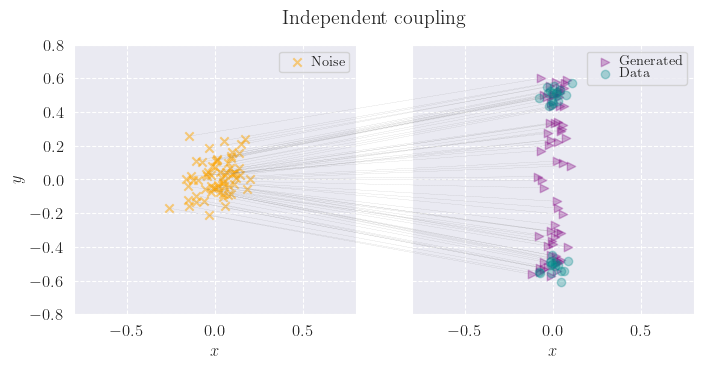

In [100]:
plot_toy(sample_noise, generated_ind, data, ind_model)
plt.savefig('plots/1_step_ind.png', bbox_inches='tight', dpi=300)

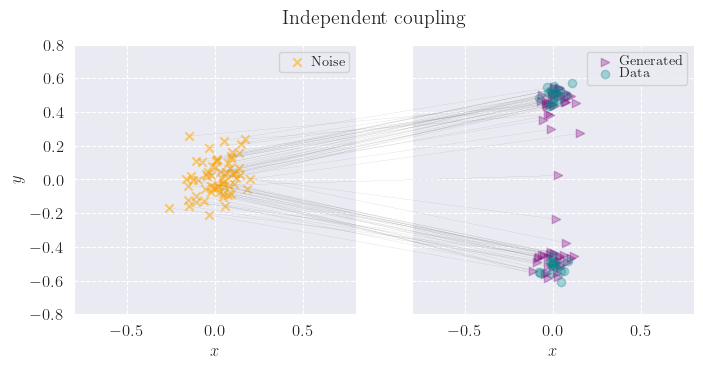

In [101]:
plot_toy(sample_noise, generated_2_ind, data, ind_model)
plt.savefig('plots/2_step_ind.png', bbox_inches='tight', dpi=300)

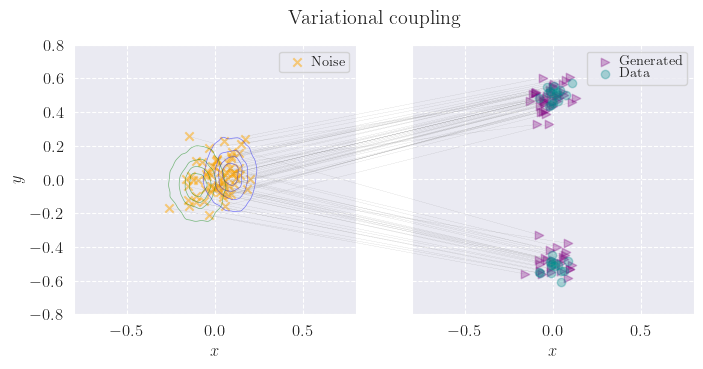

In [102]:
plot_toy(sample_noise, generated_vae, data, vae_model)
plt.savefig('plots/1_step_vae.png', bbox_inches='tight', dpi=300)

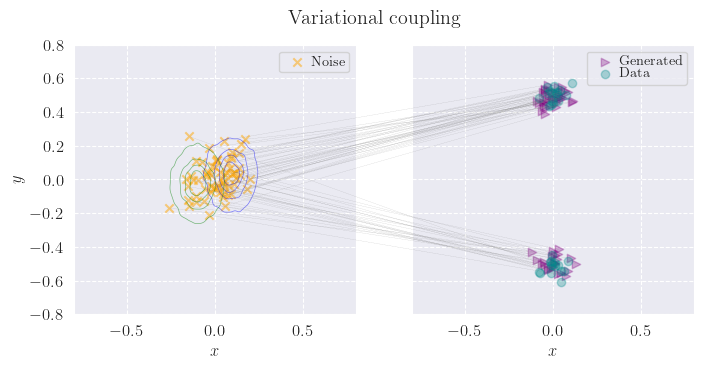

In [103]:
plot_toy(sample_noise, generated_2_vae, data, vae_model)
plt.savefig('plots/2_step_vae.png', bbox_inches='tight', dpi=300)